In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import shapiro, jarque_bera, kstest, anderson, f_oneway, levene, bartlett, kruskal, ttest_ind
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import acf, pacf
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.stattools import durbin_watson
import scipy.stats as stats
import itertools
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.stattools import arma_order_select_ic
from statsmodels.tsa.arima.model import ARIMA



In [ ]:

url = "https://drive.google.com/uc?id=1pRCFwb3-6KCIRrHDnibVuhHt_6cI4p-z"
data = pd.read_csv(url)

In [ ]:
data['Data'] = pd.to_datetime(data['Data'])
data = data.sort_values('Data').reset_index(drop=True)
data = data.set_index("Data").sort_index()

In [ ]:
all_days = pd.date_range(data.index.min(), data.index.max(), freq="B")
data = data.reindex(all_days)
data["Zamkniecie"] = data["Zamkniecie"].ffill()
data['DzienTygodnia'] = data.index.dayofweek
data['NazwaDnia'] = data.index.day_name()

In [ ]:
def oblicz_stopy_zwrotu(data, dzien_tygodnia):
    data_dzien = data[data['DzienTygodnia'] == dzien_tygodnia].copy()

    if len(data_dzien) < 2:
        return pd.DataFrame()

    # Jeśli brak notowań w danym dniu, użyj ostatniej dostępnej ceny
    # Tworzymy pełny zakres dat i forward fill
    #data_dzien = data_dzien.set_index('Data')

    # Oblicz stopy zwrotu tydzień do tygodnia
    data_dzien['Zwykla_Stopa'] = data_dzien['Zamkniecie'].pct_change()
    data_dzien['Log_Stopa'] = np.log(data_dzien['Zamkniecie'] / data_dzien['Zamkniecie'].shift(1))

    return data_dzien.reset_index()

# Oblicz stopy zwrotu dla każdego dnia tygodnia
dni_tygodnia = {
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thursday',
    4: 'Friday'
}

wyniki = {}

for dzien_num, dzien_nazwa in dni_tygodnia.items():
    data_wynik = oblicz_stopy_zwrotu(data, dzien_num)
    wyniki[dzien_nazwa] = data_wynik

Dobór parametrów dla modelu ARMA

In [ ]:
# Dane dla poniedziałku
data_mon = wyniki['Monday']['Log_Stopa'].dropna().reset_index(drop=True)

# Wybór najlepszego modelu ARMA
res_mon = arma_order_select_ic(data_mon, max_ar=5, max_ma=5, ic='aic')
p_mon, q_mon = res_mon.aic_min_order
print(f"Najlepszy model ARMA dla poniedziałku: AR={p_mon}, MA={q_mon}")

# Dopasowanie modelu
model_mon = ARIMA(data_mon, order=(p_mon, 0, q_mon)).fit()
print(model_mon.summary())

Najlepszy model ARMA dla poniedziałku: AR=2, MA=3
                               SARIMAX Results                                
Dep. Variable:              Log_Stopa   No. Observations:                  529
Model:                 ARIMA(2, 0, 3)   Log Likelihood                1228.415
Date:                Wed, 08 Oct 2025   AIC                          -2442.831
Time:                        11:59:10   BIC                          -2412.934
Sample:                             0   HQIC                         -2431.127
                                - 529                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      2.454      0.014       0.000       0.004
ar.L1         -0.0568      0.178     -0.318      0.750      -0.406       0.293
ar

In [ ]:
data_wed = wyniki['Wednesday']['Log_Stopa'].dropna().reset_index(drop=True)
res_wed = arma_order_select_ic(data_wed, max_ar=5, max_ma=5, ic='aic')
p_wed, q_wed = res_wed.aic_min_order
print(f"Najlepszy model ARMA dla środy: AR={p_wed}, MA={q_wed}")

model_wed = ARIMA(data_wed, order=(p_wed, 0, q_wed)).fit()
print(model_wed.summary())

Najlepszy model ARMA dla środy: AR=0, MA=0
                               SARIMAX Results                                
Dep. Variable:              Log_Stopa   No. Observations:                  529
Model:                          ARIMA   Log Likelihood                1261.870
Date:                Wed, 08 Oct 2025   AIC                          -2519.740
Time:                        11:59:51   BIC                          -2511.198
Sample:                             0   HQIC                         -2516.397
                                - 529                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      1.875      0.061   -9.24e-05       0.004
sigma2         0.0005   1.64e-05     30.215      0.000       0.000       0.001
Ljung-Box

Prognoza i przedziały ufności

In [ ]:
# Prognoza dla poniedziałku
forecast_mon = model_mon.get_forecast(steps=1)
pred_mon = forecast_mon.predicted_mean.values[0]
conf_int_mon = forecast_mon.conf_int(alpha=0.05).iloc[0]
print(f"Poniedziałek - prognoza: {pred_mon}, przedział ufności: {conf_int_mon.tolist()}")

# Prognoza dla środy
forecast_wed = model_wed.get_forecast(steps=1)
pred_wed = forecast_wed.predicted_mean.values[0]
conf_int_wed = forecast_wed.conf_int(alpha=0.05).iloc[0]
print(f"Środa - prognoza: {pred_wed}, przedział ufności: {conf_int_wed.tolist()}")


Poniedziałek - prognoza: 0.0020264970513467163, przedział ufności: [-0.044465219083027405, 0.04851821318572083]
Środa - prognoza: 0.002033580808607706, przedział ufności: [-0.04161714472308564, 0.04568430634030106]


Realne dane pobrane z portalu stooq

In [ ]:

url = "https://drive.google.com/uc?id=1Vtw59I2e-J6d0sKucCRC-46p0D6VDliX"
future = pd.read_csv(url)

future['Data'] = pd.to_datetime(future['Data'])
future = future.sort_values('Data').reset_index(drop=True)
future = future.set_index("Data").sort_index()
all_days = pd.date_range(future.index.min(), future.index.max(), freq="B")
future = future.reindex(all_days)
future["Zamkniecie"] = future["Zamkniecie"].ffill()
future['DzienTygodnia'] = future.index.dayofweek
future['NazwaDnia'] = future.index.day_name()

In [ ]:
wyniki_fut = {}

for dzien_num, dzien_nazwa in dni_tygodnia.items():
    data_wynik = oblicz_stopy_zwrotu(future, dzien_num)
    wyniki_fut[dzien_nazwa] = data_wynik

In [ ]:
real_value_mon = wyniki_fut['Monday'].loc[1, "Log_Stopa"]

In [ ]:
real_value_wed = wyniki_fut['Wednesday'].loc[1, "Log_Stopa"]

Porównanie wartości realnych i prognozy

In [ ]:
error_mon = real_value_mon - pred_mon
error_wed = real_value_wed - pred_wed

print(f"Poniedziałek - błąd prognozy: {error_mon}")
print(f"Środa - błąd prognozy: {error_wed}")

Poniedziałek - błąd prognozy: -0.02459659879351351
Środa - błąd prognozy: -0.021261731522558128


In [ ]:
def sprawdz_przedzial(real, conf_int):
    lower, upper = conf_int[0], conf_int[1]
    if lower <= real <= upper:
        return True
    else:
        return False

# Poniedziałek
in_conf_mon = sprawdz_przedzial(real_value_mon, conf_int_mon)
print(f"Poniedziałek - rzeczywista wartość mieści się w przedziale ufności? {in_conf_mon}")

# Środa
in_conf_wed = sprawdz_przedzial(real_value_wed, conf_int_wed)
print(f"Środa - rzeczywista wartość mieści się w przedziale ufności? {in_conf_wed}")


Poniedziałek - rzeczywista wartość mieści się w przedziale ufności? True
Środa - rzeczywista wartość mieści się w przedziale ufności? True


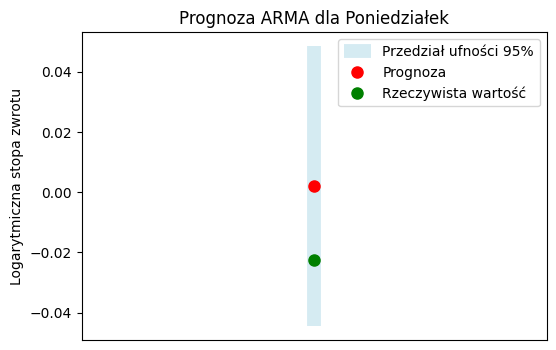

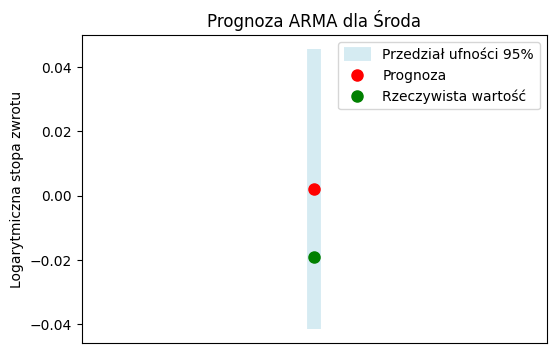

In [ ]:
import matplotlib.pyplot as plt

def plot_forecast_points(real_value, pred, conf_int, day_name):
    lower, upper = conf_int[0], conf_int[1]

    plt.figure(figsize=(6,4))
    plt.vlines(x=0, ymin=lower, ymax=upper, color='lightblue', linewidth=10, alpha=0.5, label='Przedział ufności 95%')
    plt.plot(0, pred, 'ro', markersize=8, label='Prognoza')
    plt.plot(0, real_value, 'go', markersize=8, label='Rzeczywista wartość')

    plt.title(f'Prognoza ARMA dla {day_name}')
    plt.xticks([])
    plt.ylabel('Logarytmiczna stopa zwrotu')
    plt.legend()
    plt.show()

plot_forecast_points(real_value_mon, pred_mon, conf_int_mon, 'Poniedziałek')

plot_forecast_points(real_value_wed, pred_wed, conf_int_wed, 'Środa')
